# Pairs Trading Strategy: Correlation Screening + Cointegration Testing

## Overview
This notebook implements a complete pairs trading pipeline that:
1. **Screens** potential pairs using correlation analysis
2. **Validates** candidates with rigorous cointegration testing
3. **Backtests** the strategy with proper train/test split
4. **Evaluates** performance with industry-standard metrics

### Why Correlation + Cointegration?
- **Correlation** helps narrow down candidates quickly
- **Cointegration** ensures the spread is actually mean-reverting (correlation alone doesn't guarantee this!)

**Author**: Rush Shah  
**Date**: December 2024

---
## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---
## 2. Configuration

**Choose your target stock and sector peers below.**

The strategy will:
1. Build a correlation matrix across all candidates
2. Test cointegration on highly correlated pairs
3. Select the best pair that passes statistical tests

In [2]:
# =============================================================================
# CONFIGURATION - MODIFY THIS SECTION
# =============================================================================


TARGET_STOCK = 'CELH'  # Molson Coors
PEER_STOCKS = ['BUD', 'STZ', 'SAM', 'TAP', 'MNST', 'PEP', 'KO', 'KDP','ABEV', 'SAM', 'MGPI', 'WVVI', 'SBUX', 'DEO', 'FIZZ']

# Combine into full list
ALL_TICKERS = [TARGET_STOCK] + PEER_STOCKS

# Date range
START_DATE = '2018-01-01'
END_DATE = '2024-06-01'

# Train/Test split
TRAIN_RATIO = 0.70

# Cointegration threshold
COINT_PVALUE_THRESHOLD = 0.07
MIN_CORRELATION = 0.70  # Only test pairs with correlation above this

# Trading parameters
ENTRY_ZSCORE = 2.0
EXIT_ZSCORE = 0.0
STOP_LOSS_ZSCORE = 3.5
LOOKBACK_WINDOW = 60

INITIAL_CAPITAL = 100000

print(f"Target Stock: {TARGET_STOCK}")
print(f"Peer Candidates: {PEER_STOCKS}")

Target Stock: CELH
Peer Candidates: ['BUD', 'STZ', 'SAM', 'TAP', 'MNST', 'PEP', 'KO', 'KDP', 'ABEV', 'SAM', 'MGPI', 'WVVI', 'SBUX', 'DEO', 'FIZZ']


---
## 3. Data Collection

In [3]:
# Download data for all tickers
print(f"Downloading data for {len(ALL_TICKERS)} stocks...")
data = yf.download(ALL_TICKERS, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)['Close']
data = data.dropna()

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Trading days: {len(data)}")
data.tail()


Data shape: (1614, 15)
Date range: 2018-01-02 to 2024-05-31
Trading days: 1614


Ticker,ABEV,BUD,CELH,DEO,FIZZ,KDP,KO,MGPI,MNST,PEP,SAM,SBUX,STZ,TAP,WVVI
Date,,,,,,,,,,,,,,,
2024-05-24,2.107640,63.930927,95.150002,128.851822,42.677578,32.769646,58.905842,73.722542,52.700001,167.105469,260.750000,75.899193,240.321701,50.368229,4.10
2024-05-28,2.052418,62.427013,82.919998,126.233536,42.873558,32.309589,58.734825,73.898941,51.650002,162.777374,259.510010,74.561546,237.401230,49.859837,4.19
2024-05-29,2.024806,61.217991,79.809998,123.794197,42.444263,32.261669,58.620815,73.124756,52.130001,160.683716,255.869995,73.984138,235.931290,49.916332,4.18
2024-05-30,2.034010,61.267139,78.699997,124.632446,42.621582,32.491699,58.877342,74.967087,51.240002,160.054718,256.410004,75.793327,238.464981,50.104622,4.02
2024-05-31,2.043214,61.994518,79.980003,127.231873,43.116207,32.827156,59.789433,76.064636,51.919998,162.326721,313.670013,77.198341,241.985031,51.601547,4.00


In [4]:
# Split into train/test
split_idx = int(len(data) * TRAIN_RATIO)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Training: {len(train_data)} days ({train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')})")
print(f"Testing:  {len(test_data)} days ({test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')})")

Training: 1129 days (2018-01-02 to 2022-06-27)
Testing:  485 days (2022-06-28 to 2024-05-31)


---
## 4. Step 1: Correlation Matrix Screening

First, we build a correlation matrix to identify which pairs move together. High correlation is necessary (but not sufficient!) for pairs trading.

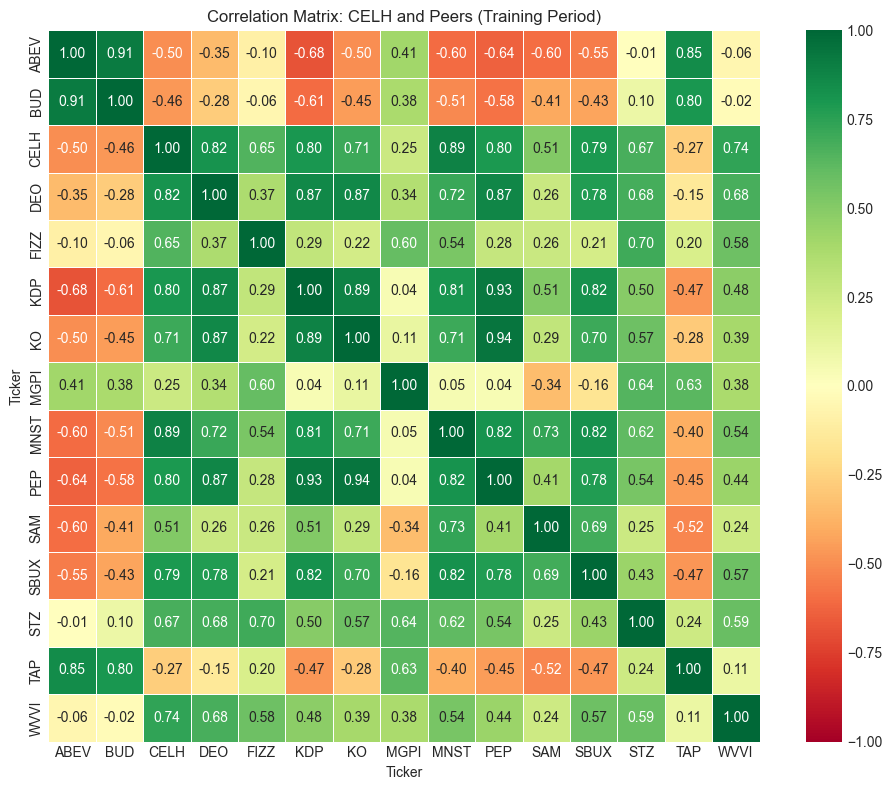

In [5]:
# Calculate correlation matrix on TRAINING data only
corr_matrix = train_data.corr()

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)
ax.set_title(f'Correlation Matrix: {TARGET_STOCK} and Peers (Training Period)', fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# Extract correlations with target stock
target_correlations = corr_matrix[TARGET_STOCK].drop(TARGET_STOCK).sort_values(ascending=False)

print(f"Correlations with {TARGET_STOCK}:")
print("=" * 40)
for ticker, corr in target_correlations.items():
    status = "✓ HIGH" if corr >= MIN_CORRELATION else "  low"
    print(f"{ticker:6} | {corr:6.3f} | {status}")

# Filter candidates
high_corr_candidates = target_correlations[target_correlations >= MIN_CORRELATION].index.tolist()
print(f"\nCandidates with correlation >= {MIN_CORRELATION}: {high_corr_candidates}")

Correlations with CELH:
MNST   |  0.890 | ✓ HIGH
DEO    |  0.820 | ✓ HIGH
KDP    |  0.803 | ✓ HIGH
PEP    |  0.797 | ✓ HIGH
SBUX   |  0.794 | ✓ HIGH
WVVI   |  0.738 | ✓ HIGH
KO     |  0.708 | ✓ HIGH
STZ    |  0.673 |   low
FIZZ   |  0.651 |   low
SAM    |  0.515 |   low
MGPI   |  0.252 |   low
TAP    | -0.272 |   low
BUD    | -0.462 |   low
ABEV   | -0.499 |   low

Candidates with correlation >= 0.7: ['MNST', 'DEO', 'KDP', 'PEP', 'SBUX', 'WVVI', 'KO']


---
## 5. Step 2: Cointegration Testing

Now we test each high-correlation pair for cointegration. **This is the critical step** - correlation alone doesn't mean the spread will mean-revert!

We use the **Engle-Granger test**:
- Null hypothesis: No cointegration
- If p-value < 0.05: Reject null → pair IS cointegrated

In [7]:
def test_pair_cointegration(series1, series2, name1, name2):
    """
    Test cointegration between two series
    Returns dict with test results
    """
    # Engle-Granger test
    coint_stat, pvalue, crit_values = coint(series1, series2)
    
    # Calculate hedge ratio
    X = add_constant(series2)
    model = OLS(series1, X).fit()
    hedge_ratio = model.params.iloc[1]
    
    # Calculate spread and test stationarity
    spread = series1 - hedge_ratio * series2
    adf_stat, adf_pvalue, _, _, adf_crit, _ = adfuller(spread)
    
    # Calculate half-life
    spread_lag = spread.shift(1).dropna()
    spread_diff = spread.diff().dropna()
    X_hl = add_constant(spread_lag)
    hl_model = OLS(spread_diff, X_hl).fit()
    theta = hl_model.params.iloc[1]
    half_life = -np.log(2) / theta if theta < 0 else np.inf
    
    return {
        'pair': f"{name1}/{name2}",
        'ticker1': name1,
        'ticker2': name2,
        'correlation': series1.corr(series2),
        'coint_pvalue': pvalue,
        'coint_stat': coint_stat,
        'adf_pvalue': adf_pvalue,
        'hedge_ratio': hedge_ratio,
        'half_life': half_life,
        'is_cointegrated': pvalue < COINT_PVALUE_THRESHOLD
    }

In [8]:
# Test cointegration for all candidate pairs
results = []

print("Testing cointegration for candidate pairs...")
print("=" * 70)

for candidate in high_corr_candidates:
    result = test_pair_cointegration(
        train_data[TARGET_STOCK], 
        train_data[candidate],
        TARGET_STOCK,
        candidate
    )
    results.append(result)
    
    status = "✓ COINTEGRATED" if result['is_cointegrated'] else "✗ Not cointegrated"
    print(f"{result['pair']:12} | corr: {result['correlation']:.3f} | "
          f"coint p-value: {result['coint_pvalue']:.4f} | {status}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 70)

Testing cointegration for candidate pairs...
CELH/MNST    | corr: 0.890 | coint p-value: 0.0642 | ✓ COINTEGRATED
CELH/DEO     | corr: 0.820 | coint p-value: 0.4502 | ✗ Not cointegrated
CELH/KDP     | corr: 0.803 | coint p-value: 0.1932 | ✗ Not cointegrated
CELH/PEP     | corr: 0.797 | coint p-value: 0.3065 | ✗ Not cointegrated
CELH/SBUX    | corr: 0.794 | coint p-value: 0.8473 | ✗ Not cointegrated
CELH/WVVI    | corr: 0.738 | coint p-value: 0.8723 | ✗ Not cointegrated
CELH/KO      | corr: 0.708 | coint p-value: 0.4705 | ✗ Not cointegrated



In [9]:
# Filter cointegrated pairs
cointegrated_pairs = results_df[results_df['is_cointegrated']].copy()

if len(cointegrated_pairs) == 0:
    print("⚠️  NO COINTEGRATED PAIRS FOUND!")
    print("\nOptions:")
    print("1. Try a different target stock or sector")
    print("2. Lower the correlation threshold")
    print("3. Use a different time period")
    print("\nThe pair with lowest p-value was:")
    best = results_df.loc[results_df['coint_pvalue'].idxmin()]
    print(f"   {best['pair']} with p-value = {best['coint_pvalue']:.4f}")
else:
    print(f"✓ Found {len(cointegrated_pairs)} cointegrated pair(s):")
    print()
    for _, row in cointegrated_pairs.iterrows():
        print(f"  {row['pair']}:")
        print(f"    Correlation: {row['correlation']:.3f}")
        print(f"    Cointegration p-value: {row['coint_pvalue']:.4f}")
        print(f"    Hedge ratio: {row['hedge_ratio']:.4f}")
        print(f"    Half-life: {row['half_life']:.1f} days")
        print()

✓ Found 1 cointegrated pair(s):

  CELH/MNST:
    Correlation: 0.890
    Cointegration p-value: 0.0642
    Hedge ratio: 1.1462
    Half-life: 38.6 days



In [10]:
# Select the best pair (lowest p-value among cointegrated pairs)
if len(cointegrated_pairs) > 0:
    best_pair = cointegrated_pairs.loc[cointegrated_pairs['coint_pvalue'].idxmin()]
    
    TICKER_1 = best_pair['ticker1']
    TICKER_2 = best_pair['ticker2']
    HEDGE_RATIO = best_pair['hedge_ratio']
    
    print("=" * 50)
    print("SELECTED PAIR FOR TRADING")
    print("=" * 50)
    print(f"Pair: {TICKER_1} / {TICKER_2}")
    print(f"Correlation: {best_pair['correlation']:.3f}")
    print(f"Cointegration p-value: {best_pair['coint_pvalue']:.4f}")
    print(f"Hedge Ratio: {HEDGE_RATIO:.4f}")
    print(f"Half-life: {best_pair['half_life']:.1f} days")
    print("=" * 50)
else:
    print("Cannot proceed without a cointegrated pair.")
    print("Please modify the configuration and try a different sector.")

SELECTED PAIR FOR TRADING
Pair: CELH / MNST
Correlation: 0.890
Cointegration p-value: 0.0642
Hedge Ratio: 1.1462
Half-life: 38.6 days


---
## 6. Visualize the Selected Pair

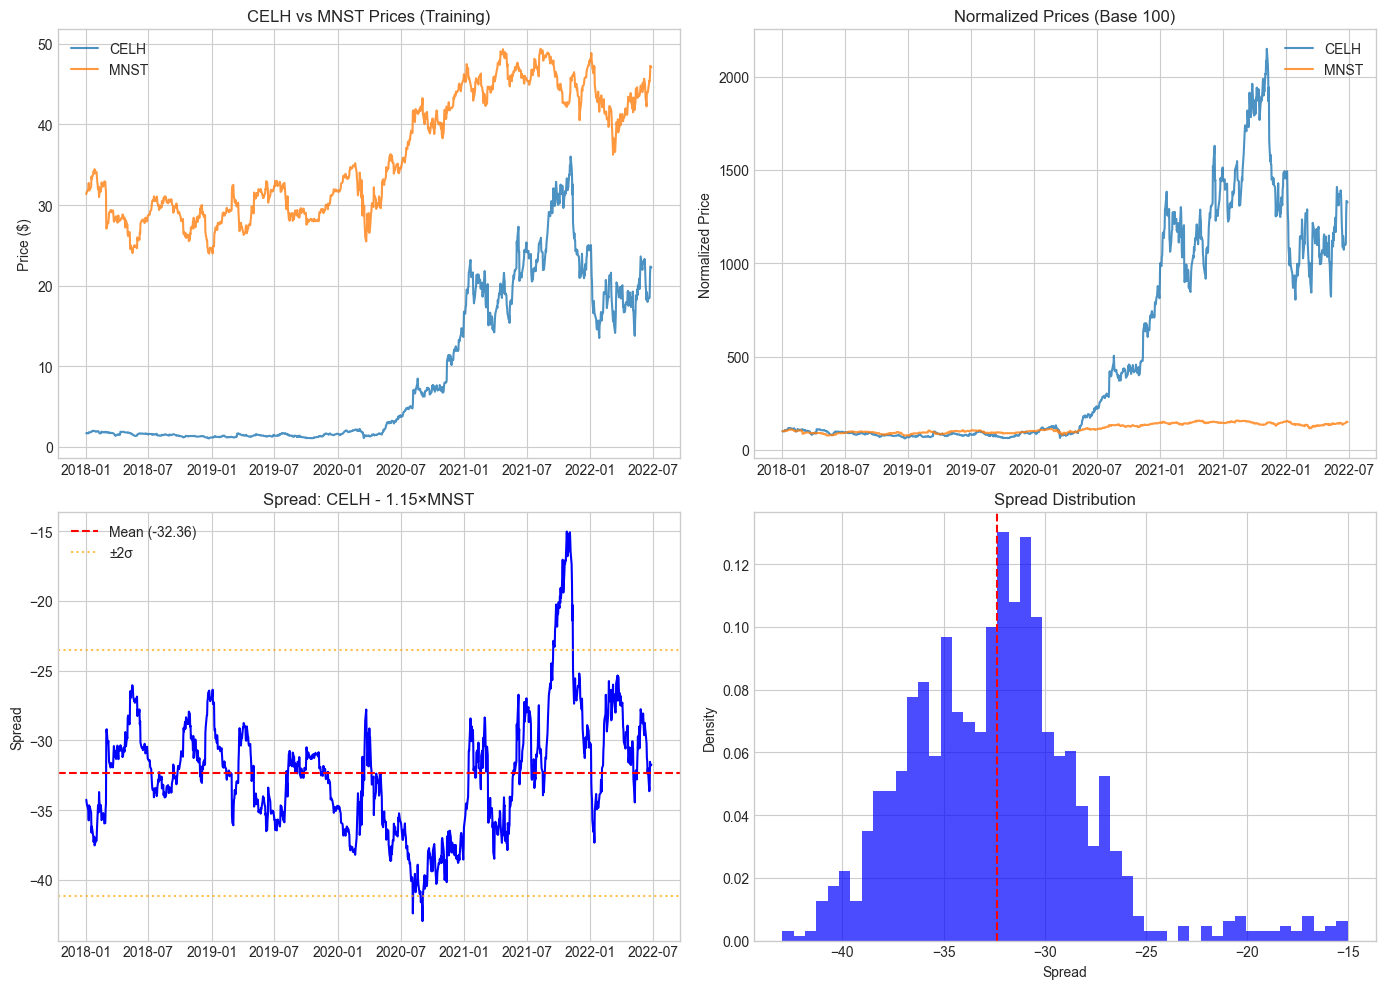

In [11]:
# Only run if we found a cointegrated pair
if len(cointegrated_pairs) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Price series
    ax1 = axes[0, 0]
    ax1.plot(train_data.index, train_data[TICKER_1], label=TICKER_1, alpha=0.8)
    ax1.plot(train_data.index, train_data[TICKER_2], label=TICKER_2, alpha=0.8)
    ax1.set_title(f'{TICKER_1} vs {TICKER_2} Prices (Training)')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    
    # Normalized prices
    ax2 = axes[0, 1]
    norm1 = train_data[TICKER_1] / train_data[TICKER_1].iloc[0] * 100
    norm2 = train_data[TICKER_2] / train_data[TICKER_2].iloc[0] * 100
    ax2.plot(train_data.index, norm1, label=TICKER_1, alpha=0.8)
    ax2.plot(train_data.index, norm2, label=TICKER_2, alpha=0.8)
    ax2.set_title('Normalized Prices (Base 100)')
    ax2.set_ylabel('Normalized Price')
    ax2.legend()
    
    # Spread
    spread = train_data[TICKER_1] - HEDGE_RATIO * train_data[TICKER_2]
    ax3 = axes[1, 0]
    ax3.plot(spread.index, spread, color='blue')
    ax3.axhline(spread.mean(), color='red', linestyle='--', label=f'Mean ({spread.mean():.2f})')
    ax3.axhline(spread.mean() + 2*spread.std(), color='orange', linestyle=':', alpha=0.7)
    ax3.axhline(spread.mean() - 2*spread.std(), color='orange', linestyle=':', alpha=0.7, label='±2σ')
    ax3.set_title(f'Spread: {TICKER_1} - {HEDGE_RATIO:.2f}×{TICKER_2}')
    ax3.set_ylabel('Spread')
    ax3.legend()
    
    # Spread distribution
    ax4 = axes[1, 1]
    ax4.hist(spread, bins=50, density=True, alpha=0.7, color='blue')
    ax4.axvline(spread.mean(), color='red', linestyle='--')
    ax4.set_title('Spread Distribution')
    ax4.set_xlabel('Spread')
    ax4.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

---
## 7. Signal Generation & Backtesting

In [12]:
def generate_signals(data, ticker1, ticker2, hedge_ratio, lookback, entry_z, exit_z, stop_z):
    """Generate trading signals based on rolling z-score"""
    df = data[[ticker1, ticker2]].copy()
    
    # Calculate spread
    df['spread'] = df[ticker1] - hedge_ratio * df[ticker2]
    
    # Rolling z-score
    df['spread_mean'] = df['spread'].rolling(window=lookback).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback).std()
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    
    # Generate positions
    position = 0
    positions = []
    
    for z in df['zscore']:
        if pd.isna(z):
            positions.append(0)
            continue
        
        if position == 0:
            if z < -entry_z:
                position = 1
            elif z > entry_z:
                position = -1
        elif position == 1:
            if z >= exit_z or z < -stop_z:
                position = 0
        elif position == -1:
            if z <= exit_z or z > stop_z:
                position = 0
        
        positions.append(position)
    
    df['position'] = positions
    df['position_change'] = df['position'].diff().fillna(0)
    
    return df


def backtest(df, ticker1, ticker2, hedge_ratio, initial_capital):
    """Run backtest and calculate returns"""
    results = df.copy()
    
    results['ret1'] = results[ticker1].pct_change()
    results['ret2'] = results[ticker2].pct_change()
    results['spread_return'] = results['position'].shift(1) * (results['ret1'] - hedge_ratio * results['ret2'])
    results['strategy_return'] = results['spread_return'].fillna(0)
    results['cumulative_return'] = (1 + results['strategy_return']).cumprod()
    results['equity'] = initial_capital * results['cumulative_return']
    
    return results


def calculate_metrics(results, initial_capital):
    """Calculate performance metrics"""
    returns = results['strategy_return'].dropna()
    equity = results['equity'].dropna()
    positions = results['position']
    
    total_return = (equity.iloc[-1] / initial_capital - 1) * 100
    trading_days = len(returns)
    years = trading_days / 252
    
    ann_return = ((1 + total_return/100) ** (1/years) - 1) * 100
    ann_vol = returns.std() * np.sqrt(252) * 100
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    max_dd = drawdown.min() * 100
    
    in_position = returns[positions.shift(1) != 0]
    win_rate = (in_position > 0).sum() / len(in_position) * 100 if len(in_position) > 0 else 0
    
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    num_trades = (results['position_change'] != 0).sum() // 2
    time_in_market = (positions != 0).sum() / len(positions) * 100
    
    return {
        'Total Return (%)': total_return,
        'Annualized Return (%)': ann_return,
        'Annualized Volatility (%)': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_dd,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Number of Trades': num_trades,
        'Time in Market (%)': time_in_market,
        'Trading Days': trading_days
    }

In [13]:
# Run backtest (only if we have a cointegrated pair)
if len(cointegrated_pairs) > 0:
    # Generate signals on TEST data
    test_signals = generate_signals(
        test_data, TICKER_1, TICKER_2, HEDGE_RATIO,
        LOOKBACK_WINDOW, ENTRY_ZSCORE, EXIT_ZSCORE, STOP_LOSS_ZSCORE
    )
    
    # Run backtest
    results = backtest(test_signals, TICKER_1, TICKER_2, HEDGE_RATIO, INITIAL_CAPITAL)
    
    # Calculate metrics
    metrics = calculate_metrics(results, INITIAL_CAPITAL)
    
    print("=" * 55)
    print(f"BACKTEST RESULTS: {TICKER_1}/{TICKER_2}")
    print("=" * 55)
    for key, value in metrics.items():
        if isinstance(value, float):
            if 'Ratio' in key or 'Factor' in key:
                print(f"{key:30} {value:>10.3f}")
            elif '%' in key:
                print(f"{key:30} {value:>10.2f}%")
            else:
                print(f"{key:30} {value:>10.2f}")
        else:
            print(f"{key:30} {value:>10}")
    print("=" * 55)

BACKTEST RESULTS: CELH/MNST
Total Return (%)                     0.66%
Annualized Return (%)                0.34%
Annualized Volatility (%)           39.27%
Sharpe Ratio                        0.009
Max Drawdown (%)                   -50.12%
Win Rate (%)                        47.87%
Profit Factor                       1.050
Number of Trades                        8
Time in Market (%)                  58.14%
Trading Days                          485


---
## 8. Results Visualization

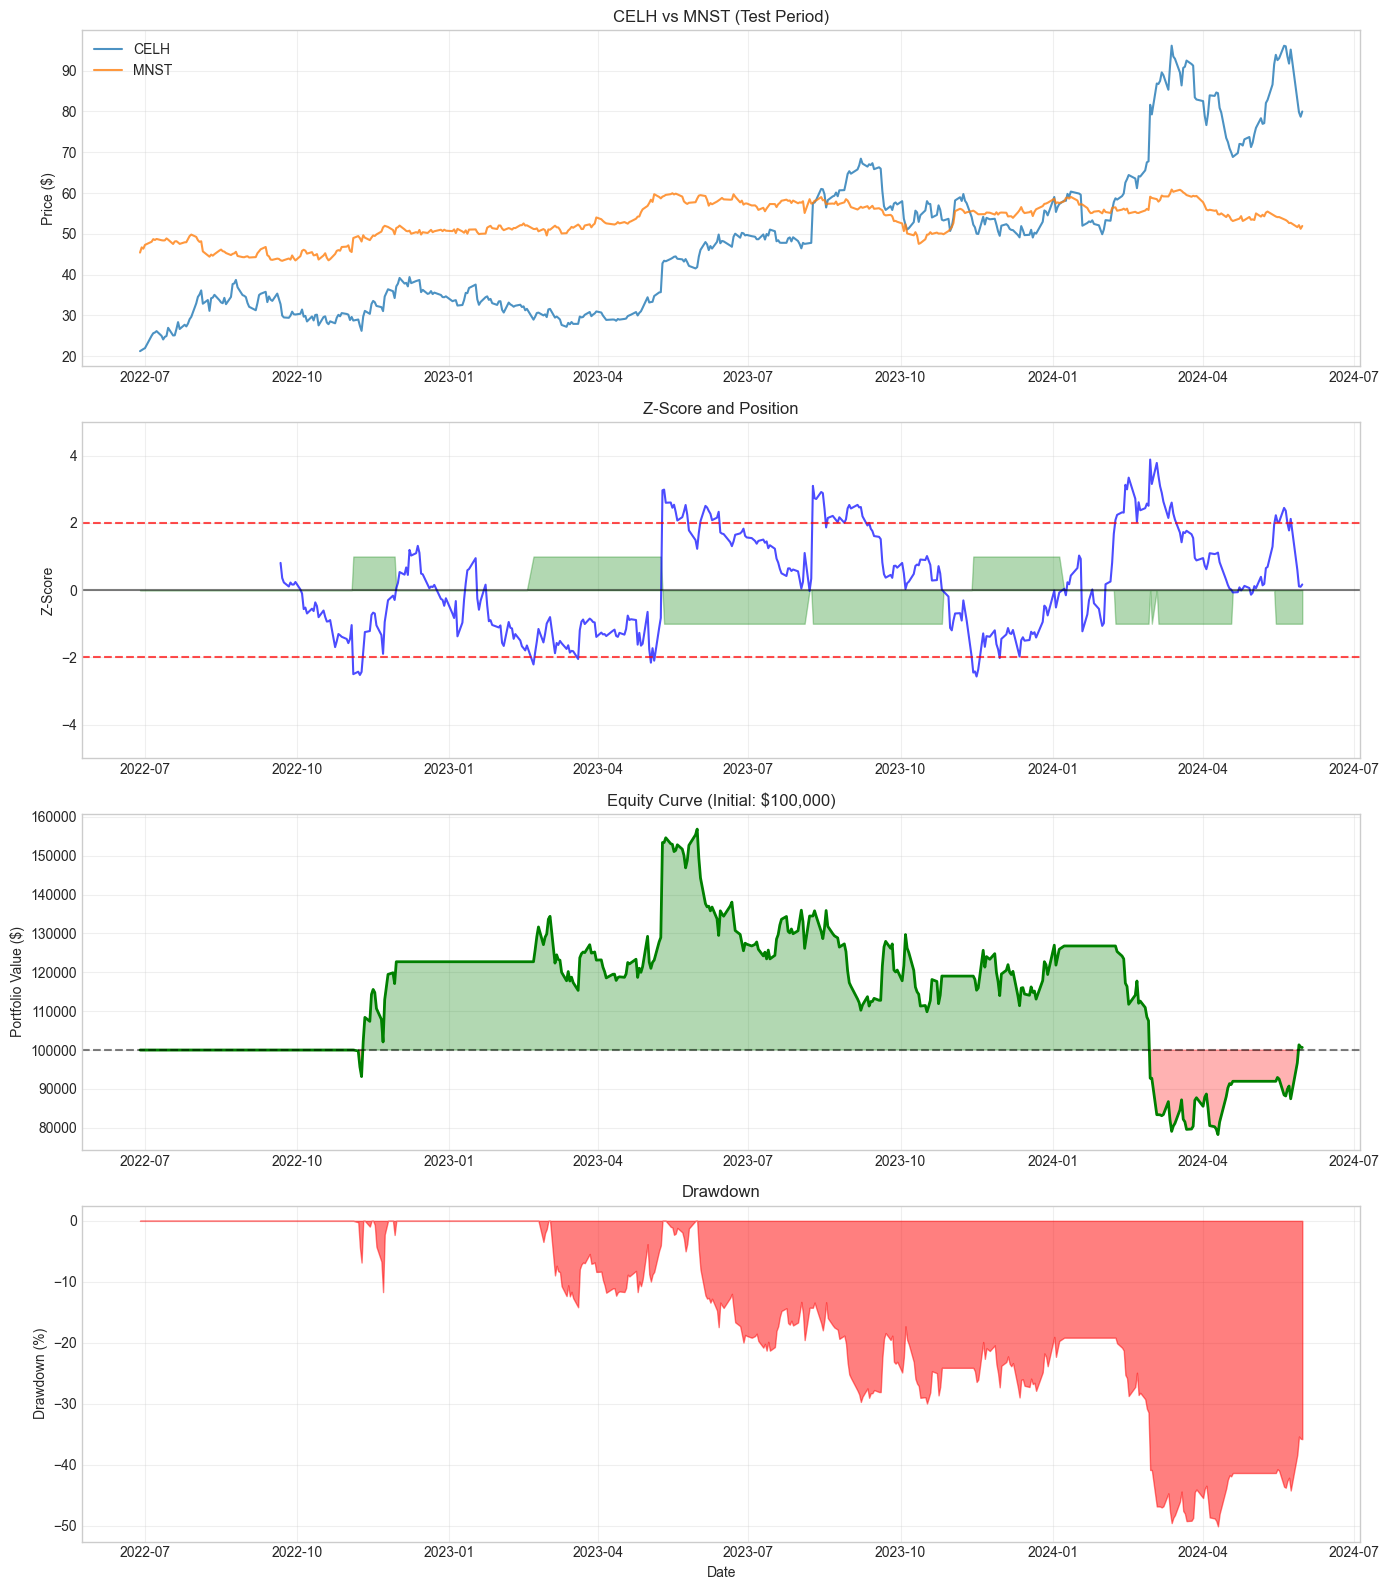


Figure saved as 'pairs_trading_results.png'


In [14]:
if len(cointegrated_pairs) > 0:
    fig, axes = plt.subplots(4, 1, figsize=(14, 16))
    
    # 1. Prices
    ax1 = axes[0]
    ax1.plot(results.index, results[TICKER_1], label=TICKER_1, alpha=0.8)
    ax1.plot(results.index, results[TICKER_2], label=TICKER_2, alpha=0.8)
    ax1.set_title(f'{TICKER_1} vs {TICKER_2} (Test Period)', fontsize=12)
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Z-score and position
    ax2 = axes[1]
    ax2.plot(results.index, results['zscore'], color='blue', alpha=0.7)
    ax2.axhline(ENTRY_ZSCORE, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(-ENTRY_ZSCORE, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(0, color='black', alpha=0.5)
    ax2.fill_between(results.index, 0, results['position'], alpha=0.3, color='green')
    ax2.set_title('Z-Score and Position', fontsize=12)
    ax2.set_ylabel('Z-Score')
    ax2.set_ylim(-5, 5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Equity
    ax3 = axes[2]
    ax3.plot(results.index, results['equity'], color='green', linewidth=2)
    ax3.axhline(INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.5)
    ax3.fill_between(results.index, INITIAL_CAPITAL, results['equity'],
                     where=results['equity'] >= INITIAL_CAPITAL, color='green', alpha=0.3)
    ax3.fill_between(results.index, INITIAL_CAPITAL, results['equity'],
                     where=results['equity'] < INITIAL_CAPITAL, color='red', alpha=0.3)
    ax3.set_title(f'Equity Curve (Initial: ${INITIAL_CAPITAL:,})', fontsize=12)
    ax3.set_ylabel('Portfolio Value ($)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Drawdown
    ax4 = axes[3]
    rolling_max = results['equity'].cummax()
    drawdown = (results['equity'] - rolling_max) / rolling_max * 100
    ax4.fill_between(results.index, 0, drawdown, color='red', alpha=0.5)
    ax4.set_title('Drawdown', fontsize=12)
    ax4.set_ylabel('Drawdown (%)')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pairs_trading_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as 'pairs_trading_results.png'")

---
## 9. Summary

### Methodology
1. **Screened** sector peers using correlation matrix
2. **Tested** high-correlation pairs for cointegration (Engle-Granger test)
3. **Selected** the pair with lowest p-value that passed significance threshold
4. **Backtested** on out-of-sample data with z-score entry/exit rules

### Key Insight
**Correlation ≠ Cointegration**. Two stocks can be highly correlated but NOT mean-reverting. The cointegration test ensures the spread will actually revert to the mean, which is essential for pairs trading.

### Limitations
- Transaction costs not included
- Slippage not modeled
- Cointegration can break down over time

### Future Improvements
- Dynamic hedge ratio (Kalman filter)
- Rolling cointegration monitoring
- Multi-pair portfolio

In [15]:
# Save results
if len(cointegrated_pairs) > 0:
    results.to_csv('pairs_trading_results.csv')
    results_df.to_csv('cointegration_screening_results.csv', index=False)
    print("Results saved to CSV files.")

Results saved to CSV files.
